# COVID-19 Notebook- Tracking The Virus 

## By David R McKenna

Because the COVID crisis is affecting the entire world and I want to be aware of what is happening without having to rely on the data being filtered through a political lens, I created this notebook. I hope you enjoy it and feel free to modify the code to investigate your own states of interest. 

### Import the necessary libraries, packages and functions to be used.

In [1]:
import numpy as np
import pandas as pd
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns
import requests, json
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings('ignore')

## Import the latest data 
 
### The data is imported from the covidtracking.com website. 

I create columns in the data frame for the Deaths per Case (DperP) and the Positive per Test as a percentage (PosPerTest). These will be used latter. I set the index to be the date as a datetime object. I then drop all the columns that are not used to speed things up a bit.

In [2]:
url = 'https://covidtracking.com/api/v1/states/daily.json'

r = requests.get(url)

json_data = r.json()

df = pd.json_normalize(json_data)

### Add calculate various relations of the data and add them as columns

df['DperP'] = df['death']/df['positive']  # Add columns Deaths per Positive case (DperP), Positive per Test (PosPerTest),  

df['PosPerTest']= df['positiveIncrease']/df['totalTestResultsIncrease']*100  # Positives per test in percentage

df['date'] = pd.to_datetime(df['date'], format = '%Y%m%d') #convert date to datetime object and set as index
df.set_index('date')

# Drop all unused columns. 

drop = ['pending',
        'hospitalizedCurrently', 'hospitalizedCumulative', 'onVentilatorCurrently',
        'onVentilatorCumulative','recovered', 'dataQualityGrade', 'lastUpdateEt',
        'dateModified','checkTimeEt', 'dateChecked','totalTestsViral', 'positiveTestsViral',
        'negativeTestsViral','positiveCasesViral', 'fips','posNeg','hash', 'commercialScore',
        'negativeRegularScore', 'negativeScore', 'positiveScore', 'score','grade']

df.drop(columns=drop, inplace=True)

## Subset and clean data:
I selected UT first because that is where I live. There were some clear outliers so I replaced them with the average over the two days. It appears that there was a correction for an overcount or overreported value so I took the sum and divided by two = 12. This may not be the exact values for each day but preserves the integrity of the average over the corrected dates. 

In [3]:
UT = df[df['state']=='UT']
UT= UT[UT['date'] >= '2020-03-15' ]

A = UT['hospitalizedIncrease'].loc[lambda x: x==389].index
B = UT['hospitalizedIncrease'].loc[lambda x: x== -365].index
C = UT['positiveIncrease'].loc[lambda x: x== 0].index

UT.loc[A,'hospitalizedIncrease'] = 12
UT.loc[B,'hospitalizedIncrease'] = 12
UT.drop(C,inplace=True)

# Create date ordinal for simplicity of plot labels
UT['date_ordinal'] = pd.to_datetime(UT['date']).apply(lambda date: date.toordinal())

## Setup global characteristics for plots. 
Plots will have the basic seaborn appearance and will have a watermark with attributions. date_ticks overcomes the issues of plotting datetime indexed datasets, especially if there is analysis, fitting, or averaging, this also allows quick scaling of the date interval presented. This is useful as the duration of the virus increases rescaling the interval provides a fast and easy way to keep the plots readable.



In [4]:
sns.set()  


def watermark(loc_x = 0.92, loc_y =0.15):
    """ Puts Property Of David McKenna on LRH corner of plots"""
    
    fig.text(loc_x,loc_y, 'Property of David McKenna \n data from: covidtracking.com',
         fontsize=10, color='gray', rotation=270,
         ha='right', va='bottom', alpha=0.75)
    
def date_ticks() :
    # Define the date format
    date_form = DateFormatter("%m-%d")
    ax.xaxis.set_major_formatter(date_form)

    # Ensure a major tick for each week using (interval=7) 
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
    plt.xticks(rotation=30)

## Define the dates where UT changes their COVID status' from Red to Orange and Orange to Yellow.
I added Memorial Day and the start of Protests as well as 7-days after each (hashed-line), to visualize possible effects these events might have on case increases. my_annotate allows for flexible location and removal of text labels.



In [5]:
OrangeDate = UT[UT['date']=='2020-04-28']['date_ordinal']
OrangeDate = int(OrangeDate)

YellowDate = UT[UT['date']=='2020-05-14']['date_ordinal']
YellowDate = int(YellowDate)

MemorialDay = UT[UT['date']=='2020-05-25']['date_ordinal']
MemorialDay = int(MemorialDay)

ProtestDate = UT[UT['date']=='2020-05-29']['date_ordinal']
ProtestDate = int(ProtestDate)

def my_annotate(text_loc, text=True) :
    """Setup the anotations of the plots- marking of significant dates"""
    
    ax.axvline(x=OrangeDate, color='tab:orange', linewidth=2)
    ax.axvline( x=YellowDate, color='gold', linewidth=2)
    ax.axvline( x=MemorialDay, color='tab:red', linewidth=1.5)
    ax.axvline( x=ProtestDate, color='tab:purple', linewidth=1.5)
    ax.axvline(x=OrangeDate + 7, color='tab:orange', linewidth=2, linestyle = '--')
    ax.axvline( x=YellowDate + 7, color='gold', linewidth=2, linestyle = '--')
    ax.axvline( x=ProtestDate + 7, color='tab:purple', linewidth=2, linestyle = '--')
    
    if text==True:
        ax.annotate('Code Orange Date', (OrangeDate - 2,text_loc),color='black',rotation=90,fontsize=13)
        ax.annotate('Code Yellow Date', (YellowDate - 2,text_loc),color='black',rotation=90,fontsize=13)
        ax.annotate('Memorial Day', (MemorialDay - 2 ,text_loc),color='black',rotation=90,fontsize=13)
        ax.annotate('Protest Start Date', (ProtestDate - 2 ,text_loc),color='black',rotation=90,fontsize=13)
        ax.annotate('Code Orange + 7-Days', (OrangeDate +5,text_loc),color='black',rotation=90,fontsize=13)
        
print('done')

done


## Plot the Daily Case Increase with 7 & 20 day rolling average
I chose to do a rolling average at 7 & 20 days to smooth out the natural oscillations in the data that may caused by difficulties of reporting during the weekend and subsequently over reporting during the following couple days. The oscillations are on the order of 3 days so the 7 day average is sufficient to smooth them out as well as be sensitive enough to react quickly to sudden spikes. The 20 day average gives a more general shape of the curve.


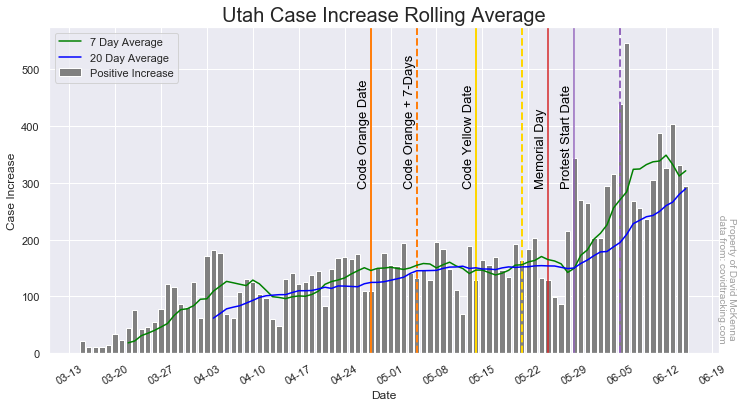

In [6]:
# Calculate the 7 & 20 day rolling averages:
UT['rolling_mean2'] = UT.loc[:,'positiveIncrease'].rolling(7).mean().shift(periods=-7)
UT['rolling_mean3'] = UT.loc[:,'positiveIncrease'].rolling(20).mean().shift(periods=-20)

#define location for the text labels on annotations
text_loc = max(UT['positiveIncrease'])-250
# Create barplot of the case increase with rolling averages overlayed.
fig, ax = plt.subplots(figsize = (12,6))
watermark()

my_annotate(text_loc)
plt.bar(UT['date'], UT['positiveIncrease'], label='Positive Increase',color='grey')
plt.plot(UT['date'], UT.rolling_mean2, label='7 Day Average', color='green')
plt.plot(UT['date'], UT.rolling_mean3, label='20 Day Average', color='blue')

date_ticks()

plt.legend(loc='upper left')
plt.title('Utah Case Increase Rolling Average', fontdict={'fontsize':20})
plt.xlabel('Date', fontdict={'fontsize':12})
plt.ylabel('Case Increase', fontdict={'fontsize':12})
plt.axis('auto')

#plt.savefig('Utah_Increase_Rolling_Avg.png')
plt.show()

## Plot the Daily Incresase in cases as well as hospitalizations
The daily increase in cases doesn't tell the whole story. The true danger of the pandemic is when the number of hospitalizations exceeds the capacity of the local healthcare system. I add to the case increase plot the fraction of those that are hospitalized. Because hospitalization often occurs after diagnosis, the daily hospitalizations may lag the case increase.


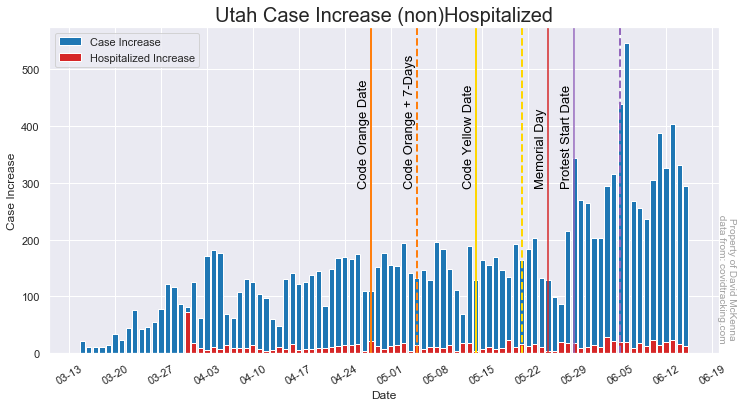

In [7]:
#Create overlapping bar plots of case increase and hospitalizations
fig, ax = plt.subplots(figsize = (12,6))
watermark()

ax.bar(UT['date'], UT['positiveIncrease'], label='Case Increase',color='tab:blue')
ax.bar(UT['date'], UT['hospitalizedIncrease'], 
       label='Hospitalized Increase',color='tab:red')

ax.legend(loc='upper left')
my_annotate(text_loc)

date_ticks()

plt.title('Utah Case Increase (non)Hospitalized', fontdict={'fontsize':20})
plt.xlabel('Date', fontdict={'fontsize':12})
plt.ylabel('Case Increase', fontdict={'fontsize':12})
plt.axis('tight')

#plt.savefig('Utah_Increase_Hospitalized.png')
plt.show()

## Plot the Daily Deaths with 7 & 20 day rolling average
Ultimately, the metric of interest is the number of deaths. As long as hospitalizations don't overwhelm the system the number of deaths should stay relatively low. If we see a sudden and sustained increase in deaths it may indicate the overwhelming of the hospitals.


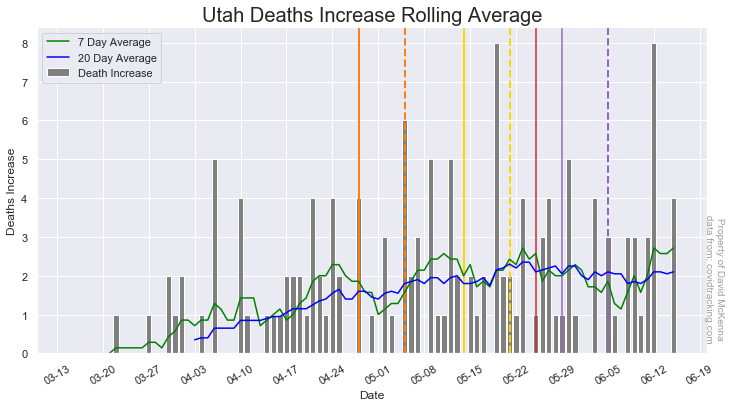

In [8]:
# Calculate the 7 & 20 day rolling averages:
UT['rolling_mean_d2'] = UT.loc[:,'deathIncrease'].rolling(7).mean().shift(periods=-6)
UT['rolling_mean_d3'] = UT.loc[:,'deathIncrease'].rolling(20).mean().shift(periods=-19)

fig, ax = plt.subplots(figsize = (12,6))
watermark()
my_annotate(text_loc,text=False)
plt.bar(UT['date'], UT['deathIncrease'], label='Death Increase',color='grey')
plt.plot(UT['date'], UT.rolling_mean_d2, label='7 Day Average', color='green')
plt.plot(UT['date'], UT.rolling_mean_d3, label='20 Day Average', color='blue')
plt.legend(loc='upper left')

date_ticks()

plt.title('Utah Deaths Increase Rolling Average', fontdict={'fontsize':20})
plt.xlabel('Date', fontdict={'fontsize':12})
plt.ylabel('Deaths Increase', fontdict={'fontsize':12})
plt.axis('tight')

#plt.savefig('Utah_Death_Rolling_Avg.png')
plt.show()

## Plot the Total tests and which of those are positive
I now turn my attention to the testing in Utah. Here I plot the daily test increase and the fraction of those that return positive. Again, the positive test may lag the total because it takes up to 48 hrs to receive results.


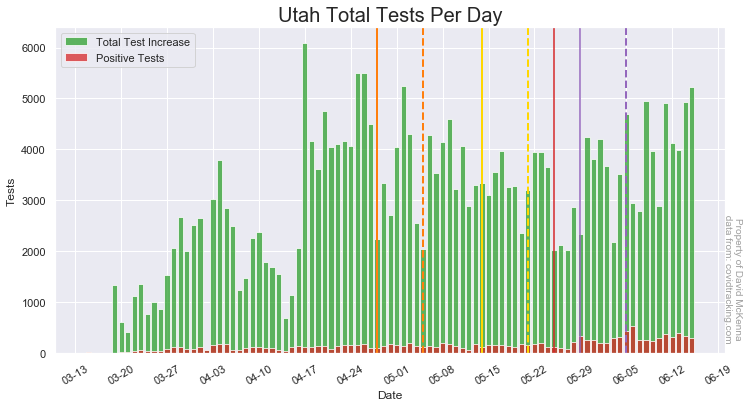

In [9]:
sns.set()

fig, ax = plt.subplots(figsize = (12,6))
watermark()
my_annotate(text_loc,text=False)

ax.bar(UT['date'], UT['totalTestResultsIncrease'],
       label='Total Test Increase',color='tab:green',alpha=0.75)
ax.bar(UT['date'], UT['positiveIncrease'],
       label='Positive Tests',color='tab:red',alpha=0.75)
date_ticks()

ax.legend(loc='upper left')
plt.title('Utah Total Tests Per Day', fontdict={'fontsize':20})
plt.xlabel('Date', fontdict={'fontsize':12})
plt.ylabel('Tests', fontdict={'fontsize':12})
plt.axis('tight')
#plt.savefig('Utah_Increase_Test.png')

plt.show()

## For clarity I plot the positive test rate as a percentage of total tests
The positive test rate can help determine if we are testing enough. A low positive test rate could indicate that the tests represent a good sample of the population. A large positive rate could indicate 1) there are not enough tests being performed for screening, 2) there is a spike in the local outbreak, 3) the virus is extremely contagious. In this case we see it level off at about 5% for a while, this gives me confidence that at that time there were sufficient tests performed and the actual infection rate was about 5%. About 5-29 the rate starts increasing which might indicate a new spike in cases, or that we have dropped below the threshold of tests per day to provide an accurate picture.


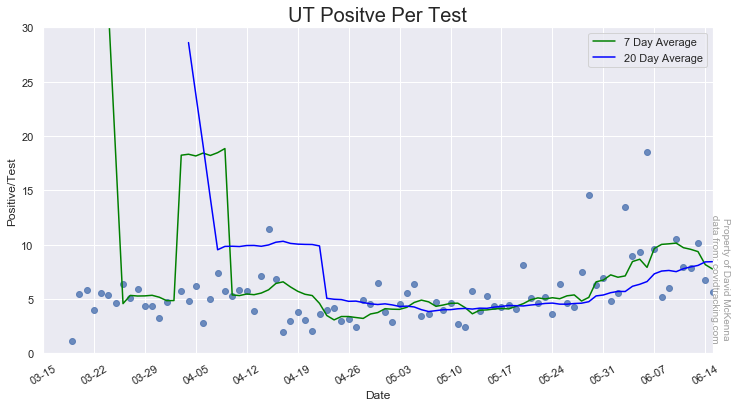

In [10]:
# calculate the 7 & 20 day rolling averages
UT['rolling_mean2'] = UT.loc[:,'PosPerTest'].rolling(7).mean().shift(periods= -7)
UT['rolling_mean3'] = UT.loc[:,'PosPerTest'].rolling(20).mean().shift(periods= -20)

fig, ax = plt.subplots(figsize = (12,6))
watermark()

fig = sns.regplot(x = 'date', y = 'PosPerTest', data = UT, fit_reg=False)
plt.plot(UT['date_ordinal'], UT.rolling_mean2, label='7 Day Average', color='green')
plt.plot(UT['date_ordinal'], UT.rolling_mean3, label='20 Day Average', color='blue')

date_ticks()

plt.legend(loc='upper right')
ax.set_xlim(UT['date'].min() , UT['date'].max() )
ax.set_ylim(0,30)
plt.title('UT Positve Per Test', fontdict={'fontsize':20})
plt.xlabel('Date', fontdict={'fontsize':12})
plt.ylabel('Positive/Test', fontdict={'fontsize':12})

#plt.savefig('UT_Positive_Per_Test.png')
plt.show()

## It is easier to see the Total Tests, Positive Tests, and the Positive per Test

From the linear fit it is clear to see that the Total Tests per day is decreasing while the Positive Tests per day is increasing, this yields a proportional increase in Positives per Test. This contradicts the claim of President of testing bias, ie. we have more cases just because we are testing more. This is the case only when not enough tests are being performed. It is also important to understand that tests IDENTIFY cases, they do NOT CREATE cases. If there are insufficient tests being done to create a representation of the population (sufficient randomized sample) then if testing is increased it will identify more cases until the sampling threshold is reached, once reached the case rate will level off at the 'true' value.

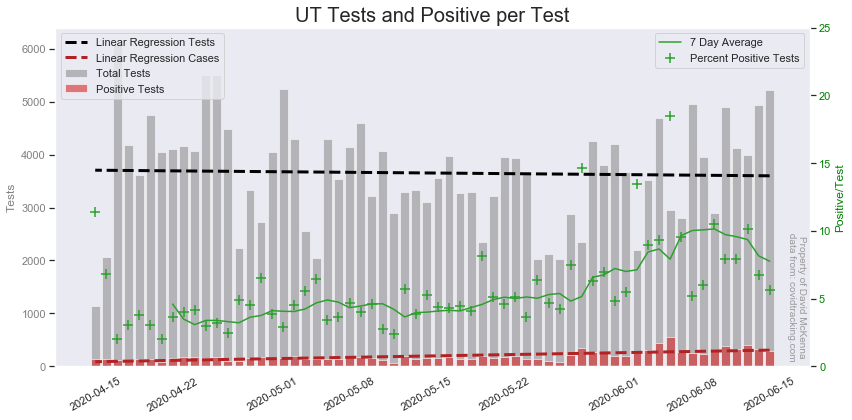

Total Tests Slope:  [-1.73478381]
Positive Tests Slope:  [3.58298708]


In [11]:
UT_1 = UT[UT['date'] >= '2020-04-15'] # select the data after the rampup of testing

UT_1['rolling_mean3'] = UT_1.loc[:,'PosPerTest'].rolling(20).mean().shift(periods= -20)
UT_1['rolling_mean2'] = UT_1.loc[:,'PosPerTest'].rolling(7).mean().shift(periods= -7)

# I use the scikit LinearRegressor to perfrom the least squares linear fit of the data

#setup the x values to be fit as ordinal because LinerRegressor doesnt like datetime objs
X_i = UT_1['date_ordinal']  
X_i = np.array(X_i).reshape(-1,1)
X_t = X_i

# Create the Y values for the two fits we will do
Y_i = UT_1['totalTestResultsIncrease']
Y_t = UT_1['positiveIncrease']


linear_regressor_i = LinearRegression()  # create object for the class
linear_regressor_i.fit(X_t, Y_i)  # perform linear regression
Y_i_pred = linear_regressor_i.predict(X_i)  # make predictions

linear_regressor_t = LinearRegression()  
linear_regressor_t.fit(X_t, Y_t)  
Y_t_pred = linear_regressor_t.predict(X_t) 


sns.set_style("dark")  # to remove grid lines because of the 2 y axis they overlap and are confusing                  
fig, ax1 = plt.subplots(figsize = (12,6))

plt.title('UT Tests and Positive per Test', fontdict={'fontsize':20})
watermark(loc_x=0.94)
date_ticks()
color = 'gray'

ax1.bar(UT_1['date'], UT_1['totalTestResultsIncrease'], 
        label='Total Tests',color='gray',alpha=0.5)
ax1.bar(UT_1['date'], UT_1['positiveIncrease'], 
        label='Positive Tests',color='tab:red',alpha=0.6)
ax1.plot(UT_1['date'],Y_i_pred, color='black',
         linestyle = '--', linewidth = 3, label = 'Linear Regression Tests')
ax1.plot(UT_1['date'],Y_t_pred, color='firebrick',
         linestyle = '--', linewidth = 3,label = 'Linear Regression Cases')
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper left')
fig = plt.ylabel('Tests', fontdict={'fontsize':12},color=color)

ax2 = ax1.twinx() 

color = 'green'
fig = plt.scatter(UT_1['date'], UT_1['PosPerTest'],
                  marker='+',s=100,color='tab:green' ,label='Percent Positive Tests')
ax2 = plt.plot(UT_1['date'], UT_1.rolling_mean2, label='7 Day Average', color='tab:green')
ax2 = plt.ylabel('Positive/Test', fontdict={'fontsize':12},color=color)
ax2 = plt.tick_params(axis='y', labelcolor=color)
ax2 = plt.ylim(0,25)
ax2 = plt.legend(loc='upper right')

fig = plt.tight_layout()

plt.savefig('UT_Test_+_Positive_Per_Test.png')
plt.show()
# Print the slopes to be clear if they are increaseing (+) or decreasing (-)
print('Total Tests Slope: ', linear_regressor_i.coef_)
print('Positive Tests Slope: ', linear_regressor_t.coef_)

## We can look closer at the Hospital situation
Here I plot the hospitalizations by day and the fraction of those that are admitted to the ICU. Again, the ICU data may lag the hospitalizations as patients are usually admitted to the hospital and then admitted to the ICU at a later date if their symptoms worse. Since space in the ICU is limited, when they become full is where we should best define the capacity of the healthcare system. Deaths that otherwise may have been prevented will occur when ICU is over capacity and triage would need to begin.


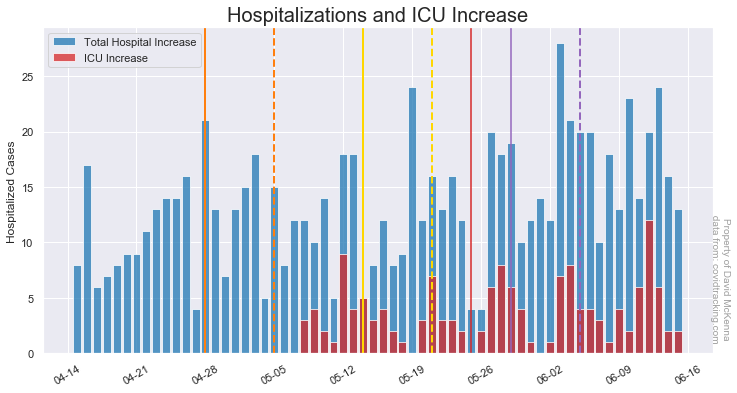

In [12]:
# again using the truncated set because ICU data wasn't available before 5-8

UT_1.sort_index() #sort by date

#create shifted column that I can then calculate the daily increase
UT_1['PreviousDayICU'] = UT_1['inIcuCumulative'].shift(-1)
# iterate through the rows to calculate in daily increase
for row in UT_1.iterrows() :
    UT_1['icuIncrease'] = UT_1['inIcuCumulative'] - UT_1['PreviousDayICU']
#drop the added column from data frame
UT_1.drop(columns = 'PreviousDayICU',inplace=True)

sns.set()# reset the plot style
fig, ax = plt.subplots(figsize = (12,6))
watermark()
my_annotate(text_loc = 18, text=False)
ax.bar(UT_1['date'], UT_1['hospitalizedIncrease'],
       label='Total Hospital Increase',color='tab:blue',alpha=0.75)
ax.bar(UT_1['date'], UT_1['icuIncrease'],
       label='ICU Increase',color='tab:red',alpha=0.75)
ax.legend(loc='upper left')
plt.title('Hospitalizations and ICU Increase', fontdict={'fontsize':20})
plt.ylabel('Hospitalized Cases', fontdict={'fontsize':12})
date_ticks()
#plt.savefig('ICU.png')
plt.show()

## Now I compare the Deaths and Deaths per case in UT with nearby states
I added in New York to the Deaths Per Case to compare. When compared the nearest states UT has one of the lowest total deaths and the lowest deaths per case. All investigated states have a level or negative slope in the deaths per case, this is good news. That means that although cases are increasing the chance of survival is also increasing. This is most likely due to better treatment plans, although it could suggest the most at risk people already got infected and were lost. I like to think it is because of better treatment. A sudden increase in deaths per case canm indicate a saturation of ICU capacity. 

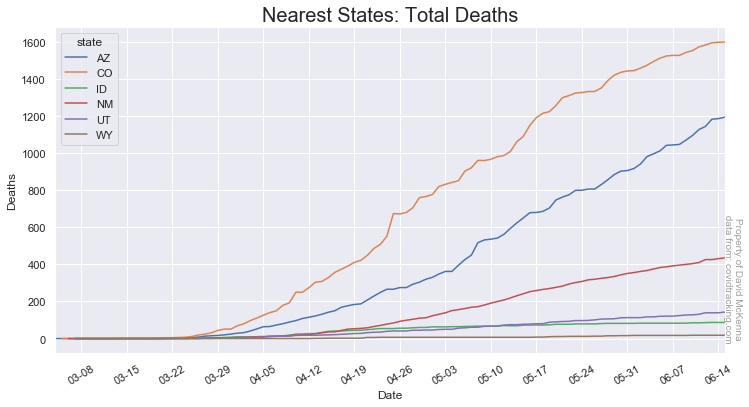

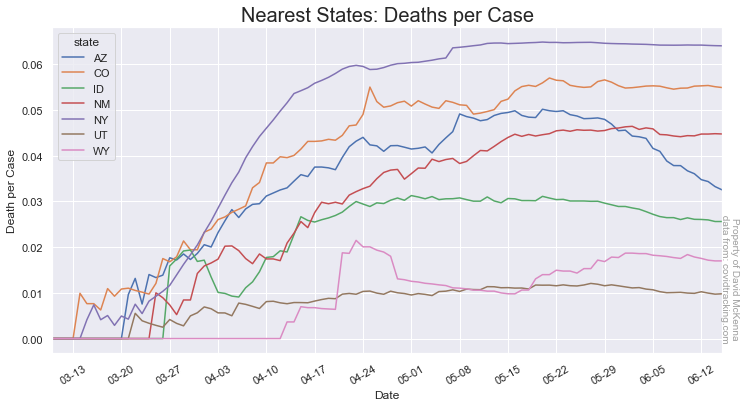

In [13]:
fc = df[df['state'].isin(['UT','AZ','CO','NM','ID','WY'])]
fc['Date'] = pd.to_datetime(df['date'].astype(str), infer_datetime_format=True)
fc['Date'] = fc[fc['date']>= '03-10-2020']

fig, ax = plt.subplots(figsize = (12,6)) 
watermark()
fig = fc.groupby(['date','state']).sum()['death'].unstack().plot(ax=ax)
date_form = DateFormatter("%m-%d")
ax.xaxis.set_major_formatter(date_form)
date_ticks()


plt.title('Nearest States: Total Deaths' , fontdict={'fontsize':20})
plt.xlabel('Date', fontdict={'fontsize':12})
plt.ylabel('Deaths', fontdict={'fontsize':12})

plt.show()

# Plot Deaths per Case
# Add NY to the dataset 
fc = df[df['state'].isin(['UT','AZ','CO','NM','ID','WY','NY'])]
fc['Date'] = pd.to_datetime(df['date'].astype(str), infer_datetime_format=True)
fc = fc[fc['Date']>= '03-10-2020']

fig, ax = plt.subplots(figsize = (12,6))
watermark()
fig = fc.groupby(['Date','state']).sum()['DperP'].unstack().plot(ax=ax)
date_ticks()
plt.title('Nearest States: Deaths per Case', fontdict={'fontsize':20}) 
plt.xlabel('Date', fontdict={'fontsize':12})
plt.ylabel('Death per Case', fontdict={'fontsize':12})

plt.show()

# Now I look at CA doing similar analysis
I will not explain as in depth since descriptions are available for the similar analysis for Utah.


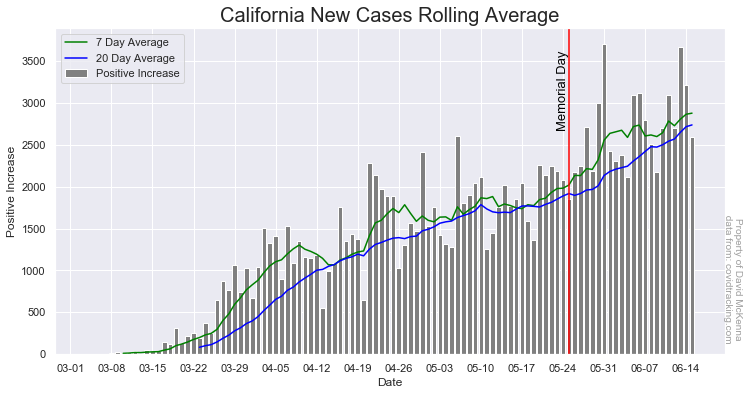

In [14]:
CA = df[df['state']=='CA']
text_loc = max(CA['positiveIncrease'])-1000

CA['rolling_mean2'] = CA.loc[:,'positiveIncrease'].rolling(7).mean().shift(periods=-6)
CA['rolling_mean3'] = CA.loc[:,'positiveIncrease'].rolling(20).mean().shift(periods=-19)

fig, ax = plt.subplots(figsize = (12,6))
watermark()
date_ticks()

plt.bar(CA['date'], CA['positiveIncrease'], 
        label='Positive Increase',color='grey')
plt.plot(CA['date'], CA.rolling_mean2,
         label='7 Day Average', color='green')
plt.plot(CA['date'], CA.rolling_mean3,
         label='20 Day Average', color='blue')
plt.legend(loc='upper left')
ax.axvline( x=MemorialDay, color='red', linewidth=1.5)
ax.annotate('Memorial Day', (MemorialDay - 2 ,text_loc),
            color='black',rotation=90,fontsize=13)
ax.set_xlim(CA['date'].min() , CA['date'].max() )

plt.title('California New Cases Rolling Average', fontdict={'fontsize':20})
plt.xlabel('Date', fontdict={'fontsize':12})
plt.ylabel('Positive Increase', fontdict={'fontsize':12})
plt.axis('tight')

#plt.savefig('CA_Increase_Rolling_Avg.png')
plt.show()

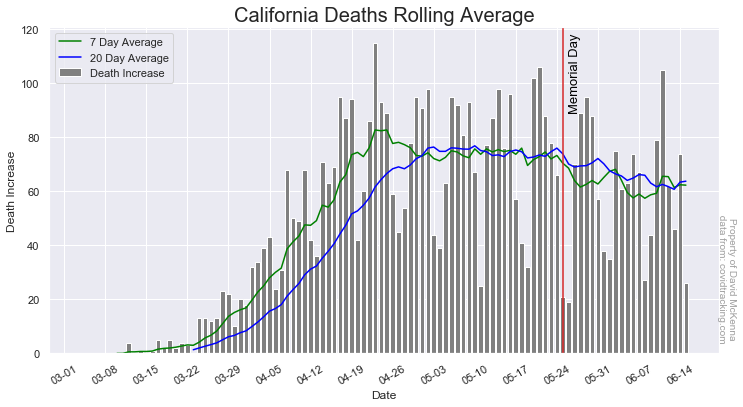

In [15]:
CA['rolling_mean_d2'] = CA.loc[:,'deathIncrease'].rolling(7).mean().shift(periods=-6)
CA['rolling_mean_d3'] = CA.loc[:,'deathIncrease'].rolling(20).mean().shift(periods=-19)
CA['date_ordinal'] = pd.to_datetime(CA['date']).apply(lambda date: date.toordinal())

fig, ax = plt.subplots(figsize = (12,6))
watermark()
date_ticks()
plt.bar(CA['date'], CA['deathIncrease'], label='Death Increase',color='grey')
#plt.plot(CA['date'], CA.rolling_mean_d, label='3 Day Average', color='red')
plt.plot(CA['date'], CA.rolling_mean_d2, label='7 Day Average', color='green')
plt.plot(CA['date'], CA.rolling_mean_d3, label='20 Day Average', color='blue')
plt.legend(loc='upper left')
plt.xticks(rotation=30)
ax.axvline( x=MemorialDay, color='tab:red', linewidth=1.5)
ax.annotate('Memorial Day', (MemorialDay + 1 ,90),color='black',rotation=90,fontsize=13)
ax.set_xlim(CA['date_ordinal'].min() , CA['date_ordinal'].max() )
plt.title('California Deaths Rolling Average', fontdict={'fontsize':20})
plt.xlabel('Date', fontdict={'fontsize':12})
plt.ylabel('Death Increase', fontdict={'fontsize':12})
plt.axis('tight')

#plt.savefig('CA_Death_Rolling_Avg.png')
plt.show()

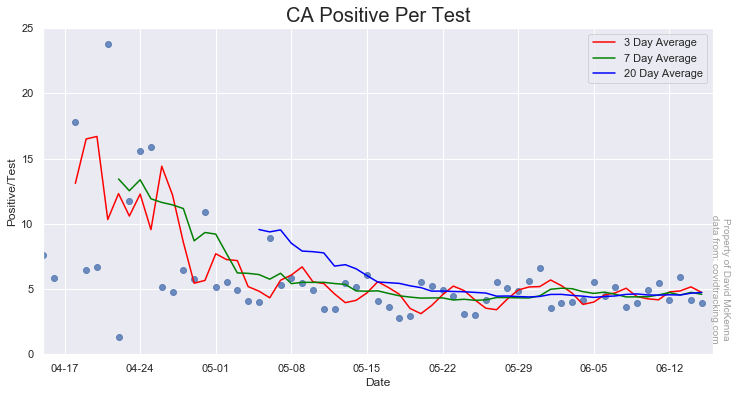

In [16]:
CA_1 = CA[CA['date'] >= '2020-04-15' ]

CA_1['rolling_mean'] = CA_1.loc[:,'PosPerTest'].rolling(3).mean().shift(periods=-3)
CA_1['rolling_mean2'] = CA_1.loc[:,'PosPerTest'].rolling(7).mean().shift(periods=-7)
CA_1['rolling_mean3'] = CA_1.loc[:,'PosPerTest'].rolling(20).mean().shift(periods=-20)

fig, ax = plt.subplots(figsize = (12,6))
watermark()
date_ticks()

fig = sns.regplot(x = 'date_ordinal', y = 'PosPerTest', data = CA, fit_reg=False)
plt.plot(CA_1['date'], CA_1.rolling_mean, label='3 Day Average', color='red')
plt.plot(CA_1['date'], CA_1.rolling_mean2, label='7 Day Average', color='green')
plt.plot(CA_1['date'], CA_1.rolling_mean3, label='20 Day Average', color='blue')

plt.legend(loc='upper right')
ax.set_xlim(CA_1['date_ordinal'].min() , CA_1['date_ordinal'].max()+ 1 )
ax.set_ylim(0,25)
plt.title('CA Positive Per Test', fontdict={'fontsize':20})
plt.xlabel('Date', fontdict={'fontsize':12})
plt.ylabel('Positive/Test', fontdict={'fontsize':12})

#plt.savefig('CA_Positive_Per_Test.png')
plt.show()

# Now I look at the 10 states with the largest case increases.

I take the 7 day average of the case increase of all states then I choose the 10 largest. I plot these on a horizontal bar plot in decsending order.

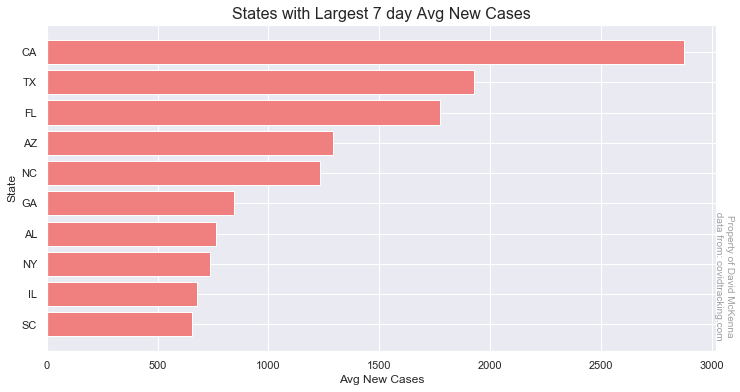

In [17]:
today = str(df.date.max())

df_tot = df[['state','date','positiveIncrease','deathIncrease','totalTestResultsIncrease']].reset_index()
df_tot['Date'] = pd.to_datetime(df['date'], format= '%Y%m%d')
df_tot.set_index(['state','Date'],inplace=True)
df_tot.sort_index(inplace=True)
df_tot['date_ordinal'] = pd.to_datetime(df_tot['date']).apply(lambda date: date.toordinal())
df_tot['posDiff'] = df_tot.groupby(level='state')['positiveIncrease'].apply(lambda x: (x.rolling(7).mean()))

largest = df_tot[df_tot['date']==today]['posDiff'].nlargest(10).astype(int)

fig, ax = plt.subplots(figsize = (12,6))
watermark()

df_2 = pd.DataFrame(largest).reset_index().sort_index(ascending=False)
plt.barh(df_2.state,df_2.posDiff,color = 'lightcoral')
plt.title('States with Largest 7 day Avg New Cases', fontsize=16)
plt.ylabel('State')
plt.xlabel('Avg New Cases')
#plt.savefig('Top_Ten_Increase.png')
plt.show()

## Since total increase only tells part of the story:
### I plot the 10 states with the largest 7-day average increase scaled by population.  It was suggested to me that they might have more cases because they are testing a lot more (Trump loves this argument) so I added the 7-day average of tests per day per 1M population. 
I import a dataset that contains the 2019 state populations. I create a state name and abbreviation dictionary so I can map the abbreviations in the covidtracking dataset to the state names in the population dataset. I then merge the datasets and plot.

In [18]:
names = ['State','Census','Estimates Base','2010','2011','2012','2013','2014','2015','2016','2017','2018','2019']
drop = ['Census','Estimates Base','2010','2011','2012','2013','2014','2015','2016','2017','2018']
pop = pd.read_excel('pop_data.xlsx',header=4,names=names)
pop.drop(columns=drop,inplace=True) #drop the unused columns

In [19]:
# Create the states names and abbreviations dictionary:
states = {
        'AK': '.Alaska',
        'AL': '.Alabama',
        'AR': '.Arkansas',
        'AS': '.American Samoa',
        'AZ': '.Arizona',
        'CA': '.California',
        'CO': '.Colorado',
        'CT': '.Connecticut',
        'DC': '.District of Columbia',
        'DE': '.Delaware',
        'FL': '.Florida',
        'GA': '.Georgia',
        'GU': '.Guam',
        'HI': '.Hawaii',
        'IA': '.Iowa',
        'ID': '.Idaho',
        'IL': '.Illinois',
        'IN': '.Indiana',
        'KS': '.Kansas',
        'KY': '.Kentucky',
        'LA': '.Louisiana',
        'MA': '.Massachusetts',
        'MD': '.Maryland',
        'ME': '.Maine',
        'MI': '.Michigan',
        'MN': '.Minnesota',
        'MO': '.Missouri',
        'MP': '.Northern Mariana Islands',
        'MS': '.Mississippi',
        'MT': '.Montana',
        'NA': '.National',
        'NC': '.North Carolina',
        'ND': '.North Dakota',
        'NE': '.Nebraska',
        'NH': '.New Hampshire',
        'NJ': '.New Jersey',
        'NM': '.New Mexico',
        'NV': '.Nevada',
        'NY': '.New York',
        'OH': '.Ohio',
        'OK': '.Oklahoma',
        'OR': '.Oregon',
        'PA': '.Pennsylvania',
        'PR': '.Puerto Rico',
        'RI': '.Rhode Island',
        'SC': '.South Carolina',
        'SD': '.South Dakota',
        'TN': '.Tennessee',
        'TX': '.Texas',
        'UT': '.Utah',
        'VA': '.Virginia',
        'VI': '.Virgin Islands',
        'VT': '.Vermont',
        'WA': '.Washington',
        'WI': '.Wisconsin',
        'WV': '.West Virginia',
        'WY': '.Wyoming'
}

In [20]:
# Subset the dataset with only the columns of interest, this speeds up the merge:
df_1 = df[['state','date','positiveIncrease','deathIncrease','totalTestResultsIncrease']].reset_index()
df_1['full'] = df_1['state'].map(states)

# Merge datasets
df_pop = pd.merge(df_1,pop, left_on='full',right_on='State')
df_pop.drop(columns=['full','State'],inplace=True)

today = str(df_pop.date.max())
# sort index by formated date
df_pop['Date'] = pd.to_datetime(df_pop['date'], format= '%Y%m%d')
df_pop.set_index(['state','Date'],inplace=True)
df_pop.sort_index(inplace=True)

#calculate the scaled values
df_pop['PosIncScaled'] = df_pop['positiveIncrease'] / (df_pop['2019']/1000000)
df_pop['TestIncScaled'] = df_pop['totalTestResultsIncrease'] / (df_pop['2019']/1000000)

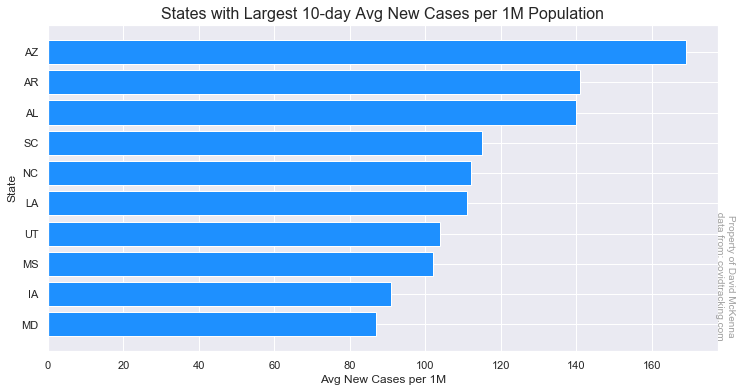

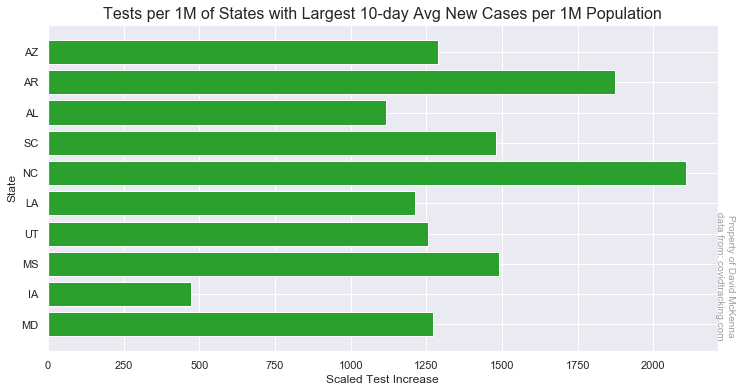

In [21]:
df_pop['PosDiffScaled'] = df_pop.groupby(level='state')['PosIncScaled'].apply(lambda x: (x.rolling(10).mean()))
df_pop['TestIncScaled_m'] = df_pop.groupby(level='state')['TestIncScaled'].apply(lambda x: (x.rolling(10).mean()))

largest = df_pop[df_pop['date']==today]['PosDiffScaled'].nlargest(10).astype(int)


fig, ax = plt.subplots(figsize = (12,6))
watermark()

df_2 = pd.DataFrame(largest).reset_index().sort_index(ascending=False)
plt.barh(df_2.state,df_2.PosDiffScaled,color = 'dodgerblue')
plt.title('States with Largest 10-day Avg New Cases per 1M Population', fontsize=16)
plt.ylabel('State')
plt.xlabel('Avg New Cases per 1M')
plt.savefig('Top_Ten_Increase.png')
plt.show()

# create a list of the 10 states from above
states = list(df_2.state)

# define the 
l = df_pop[df_pop['date']==today]
l.reset_index(inplace=True)
l = l[l['state'].isin(states)]

df_2 = pd.DataFrame(l).reset_index().sort_index(ascending=False)

fig, ax = plt.subplots(figsize = (12,6))
watermark()


plt.barh(df_2.state,df_2.TestIncScaled_m, color = 'tab:green')
plt.title('Tests per 1M of States with Largest 10-day Avg New Cases per 1M Population', fontsize=16)
plt.ylabel('State')
plt.xlabel('Scaled Test Increase')
ax.set_yticklabels(states) #Order the states in terms of largest per 1M increase to match the previous plot
plt.savefig('Top_Ten_Increase_tests.png')
plt.show()